In [356]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import matthews_corrcoef,f1_score,make_scorer
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm

#Ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [357]:
df = pd.read_csv('data/train.csv',index_col = 'Loan_ID')
df.sample(5)

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
Loan_ID,,,,,,,,,,,,
LP002337,Female,No,0,Graduate,No,2995,0.000000,60.0,360.0,1.0,Urban,Y
LP001922,Male,Yes,0,Graduate,No,20667,0.000000,NaN,360.0,1.0,Rural,N
LP001846,Female,No,3+,Graduate,No,3083,0.000000,255.0,360.0,1.0,Rural,Y
LP002219,Male,Yes,3+,Graduate,No,8750,4996.000000,130.0,360.0,1.0,Rural,Y
LP002369,Male,Yes,0,Graduate,No,2920,16.120001,87.0,360.0,1.0,Rural,Y


In [358]:
#Check for incorrect values
for col in df.columns:
    print(col)
    print(df[col].value_counts(),'\n')

Gender
Male      489
Female    112
Name: Gender, dtype: int64 

Married
Yes    398
No     213
Name: Married, dtype: int64 

Dependents
0     345
1     102
2     101
3+     51
Name: Dependents, dtype: int64 

Education
Graduate        480
Not Graduate    134
Name: Education, dtype: int64 

Self_Employed
No     500
Yes     82
Name: Self_Employed, dtype: int64 

ApplicantIncome
2500    9
4583    6
6000    6
2600    6
3333    5
       ..
3244    1
4408    1
3917    1
3992    1
7583    1
Name: ApplicantIncome, Length: 505, dtype: int64 

CoapplicantIncome
0.0       273
2500.0      5
2083.0      5
1666.0      5
2250.0      3
         ... 
2791.0      1
1010.0      1
1695.0      1
2598.0      1
240.0       1
Name: CoapplicantIncome, Length: 287, dtype: int64 

LoanAmount
120.0    20
110.0    17
100.0    15
160.0    12
187.0    12
         ..
240.0     1
214.0     1
59.0      1
166.0     1
253.0     1
Name: LoanAmount, Length: 203, dtype: int64 

Loan_Amount_Term
360.0    512
180.0     44
480.

In [359]:
print('NaN Values')
df.isna().sum().sort_values(ascending=False) #Ascending order

NaN Values


Credit_History       50
Self_Employed        32
LoanAmount           22
Dependents           15
Loan_Amount_Term     14
Gender               13
Married               3
Education             0
ApplicantIncome       0
CoapplicantIncome     0
Property_Area         0
Loan_Status           0
dtype: int64

## Preprocessing and EDA

In [360]:
x = df.isna().sum().sort_values(ascending=False)
x = x.loc[x>0].index
print(x)

Index(['Credit_History', 'Self_Employed', 'LoanAmount', 'Dependents',
       'Loan_Amount_Term', 'Gender', 'Married'],
      dtype='object')


In [361]:
df['LoanAmount'] = df['LoanAmount'].fillna(int(df['LoanAmount'].dropna().mean()))
for col in x:
    df[col] = df[col].fillna(df[col].dropna().mode().values[0]) 
df.isna().sum().sort_values(ascending=False)

Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64

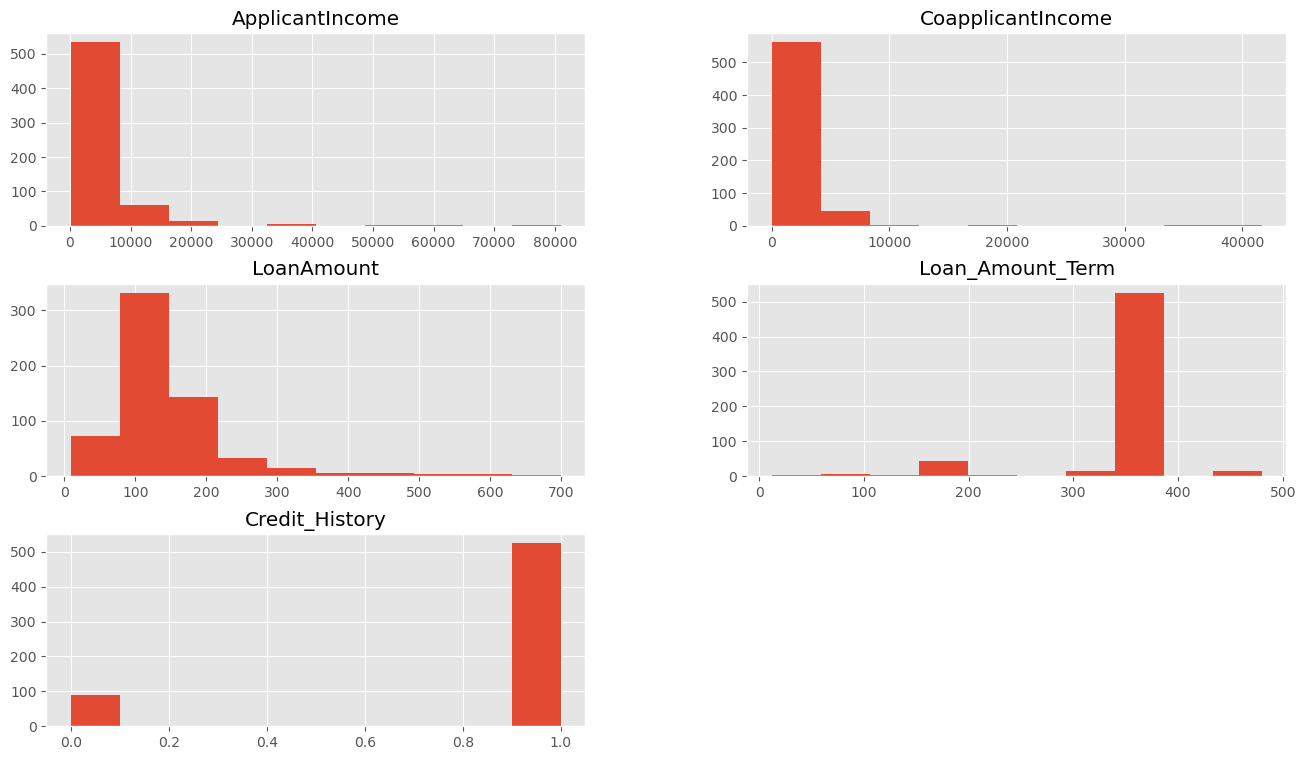

In [362]:
df.hist()
plt.show()

[Text(0.5, 1.0, 'Loan requests by gender')]

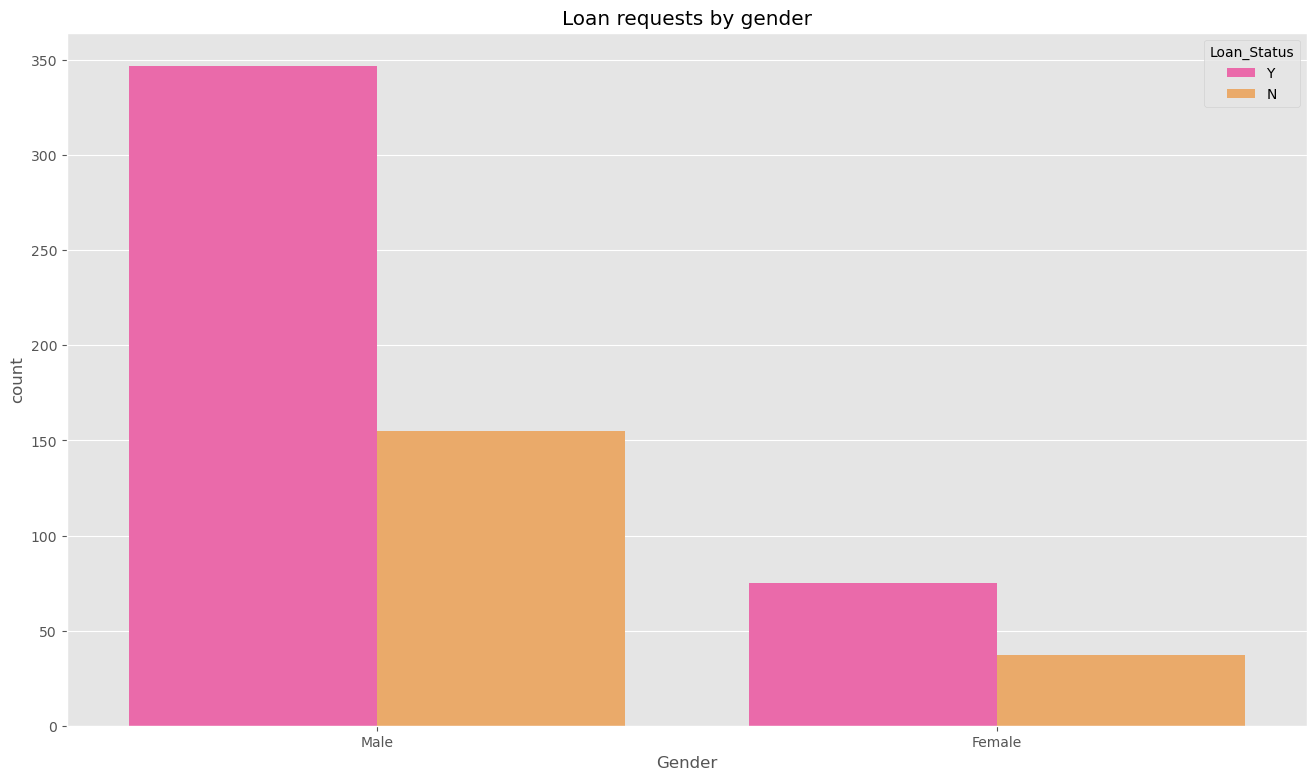

In [363]:
sns.countplot(x = df['Gender'],hue=df['Loan_Status'],palette='spring').set(title='Loan requests by gender')

[Text(0.5, 1.0, 'Loan requests by credit history')]

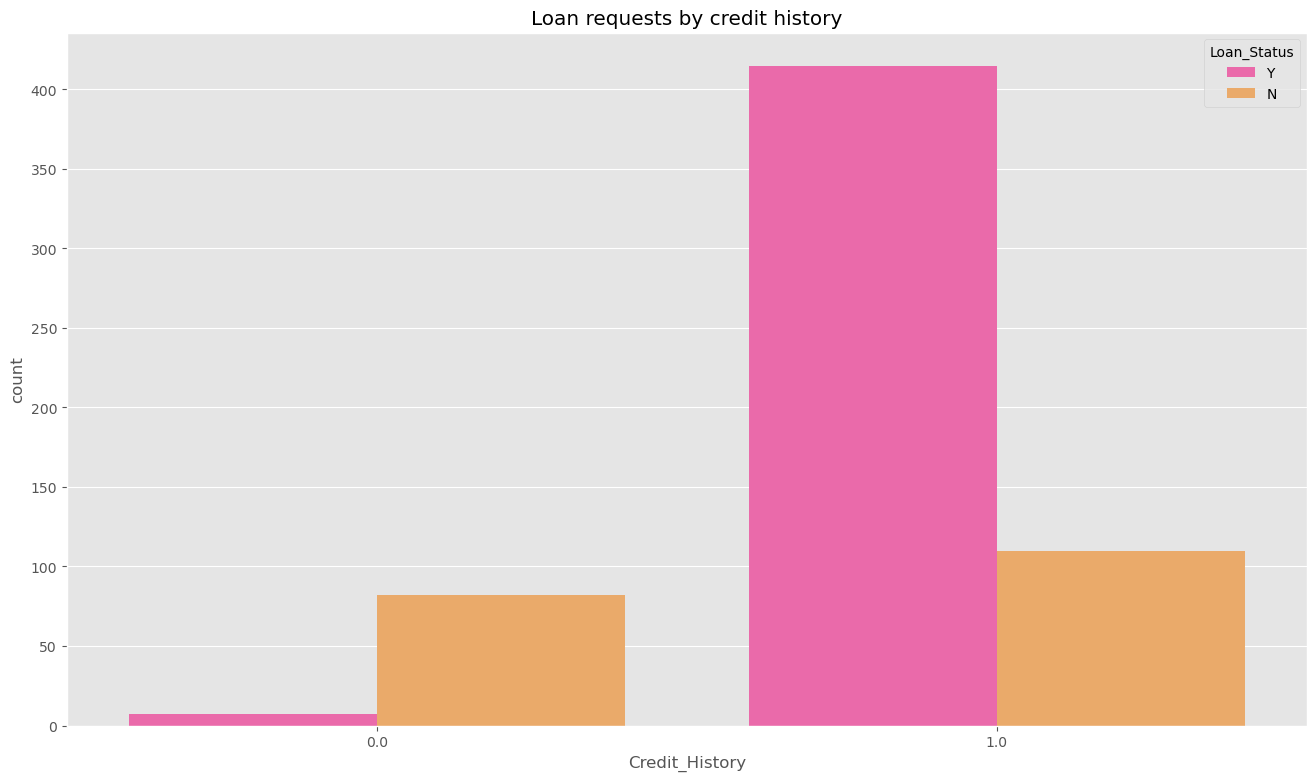

In [364]:
sns.countplot(x = df['Credit_History'],hue=df['Loan_Status'],palette='spring').set(title='Loan requests by credit history')

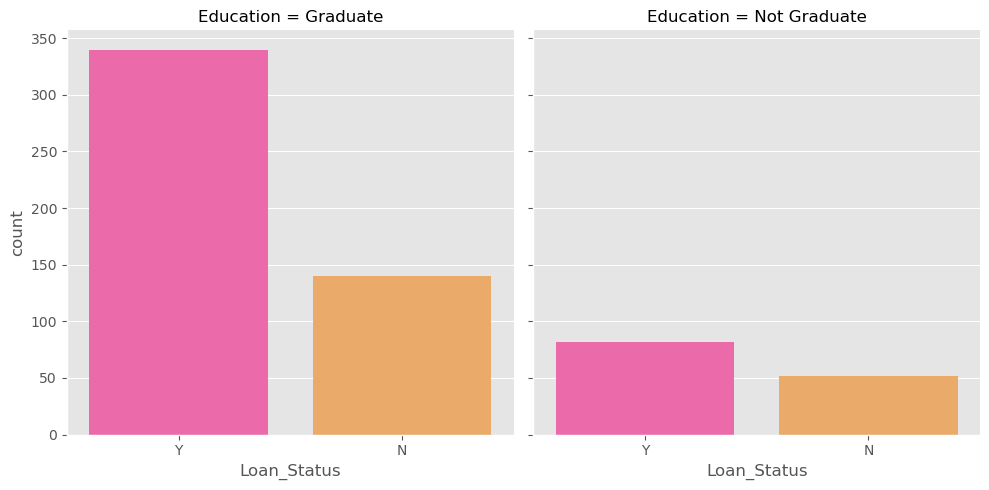

In [365]:
sns.catplot(x = 'Loan_Status',palette='spring',col='Education',data = df,kind="count")

In [366]:
def transform_categorical(df):
    '''
    Convert categorical variables to numerical variables.
    '''
    df['Gender']=df['Gender'].map({'Male':1,'Female':0})
    df['Married']=df['Married'].map({'Yes':1,'No':0})
    df['Education']=df['Education'].map({'Graduate':1,'Not Graduate':0})
    df['Self_Employed']=df['Self_Employed'].map({'Yes':1,'No':0})
    if 'Loan_Status' in df:
        df['Loan_Status']=df['Loan_Status'].map({'Y':1,'N':0})
    df = pd.get_dummies(df,drop_first=True)
    return df

In [367]:
df = transform_categorical(df)
df

,Gender,Married,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Loan_Status,Dependents_1,Dependents_2,Dependents_3+,Property_Area_Semiurban,Property_Area_Urban
Loan_ID,,,,,,,,,,,,,,,
LP001002,1,0,1,0,5849,0.0,146.0,360.0,1.0,1,0,0,0,0,1
LP001003,1,1,1,0,4583,1508.0,128.0,360.0,1.0,0,1,0,0,0,0
LP001005,1,1,1,1,3000,0.0,66.0,360.0,1.0,1,0,0,0,0,1
LP001006,1,1,0,0,2583,2358.0,120.0,360.0,1.0,1,0,0,0,0,1
LP001008,1,0,1,0,6000,0.0,141.0,360.0,1.0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LP002978,0,0,1,0,2900,0.0,71.0,360.0,1.0,1,0,0,0,0,0
LP002979,1,1,1,0,4106,0.0,40.0,180.0,1.0,1,0,0,1,0,0
LP002983,1,1,1,0,8072,240.0,253.0,360.0,1.0,1,1,0,0,0,1


In [368]:
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm').format(precision=2)

,Gender,Married,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Loan_Status,Dependents_1,Dependents_2,Dependents_3+,Property_Area_Semiurban,Property_Area_Urban
Gender,1.00,0.36,-0.05,-0.00,0.06,0.08,0.11,-0.07,0.01,0.02,-0.00,0.13,0.10,-0.11,0.03
Married,0.36,1.00,-0.01,0.00,0.05,0.08,0.15,-0.10,0.01,0.09,0.11,0.25,0.13,0.01,0.00
Education,-0.05,-0.01,1.00,0.01,0.14,0.06,0.17,0.07,0.07,0.09,0.01,-0.02,-0.06,0.04,0.03
Self_Employed,-0.00,0.00,0.01,1.00,0.13,-0.02,0.12,-0.03,-0.00,-0.00,0.08,0.03,0.00,0.01,-0.03
ApplicantIncome,0.06,0.05,0.14,0.13,1.00,-0.12,0.57,-0.05,-0.02,-0.00,0.04,-0.03,0.16,-0.01,-0.00
CoapplicantIncome,0.08,0.08,0.06,-0.02,-0.12,1.00,0.19,-0.06,0.01,-0.06,-0.03,0.01,0.04,-0.03,0.02
LoanAmount,0.11,0.15,0.17,0.12,0.57,0.19,1.00,0.04,-0.00,-0.04,0.06,0.02,0.15,-0.01,-0.03
Loan_Amount_Term,-0.07,-0.10,0.07,-0.03,-0.05,-0.06,0.04,1.00,-0.00,-0.02,-0.09,-0.01,-0.08,0.06,-0.09
Credit_History,0.01,0.01,0.07,-0.00,-0.02,0.01,-0.00,-0.00,1.00,0.54,0.01,0.01,-0.06,0.04,-0.02
Loan_Status,0.02,0.09,0.09,-0.00,-0.00,-0.06,-0.04,-0.02,0.54,1.00,-0.04,0.06,-0.03,0.14,-0.04


## Train Test Split and Standardization

In [369]:
y = df['Loan_Status'].values
x = df.drop(labels = 'Loan_Status',axis=1).values
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=10,test_size=0.1)

In [370]:
scaler = StandardScaler()
scaler.fit(x_train)# The models are fit with the train data!
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

## PCA

In [371]:
pca = PCA(svd_solver = 'full',random_state = 0)
pca.fit(x_train)
x_pca = pca.transform(x_train)

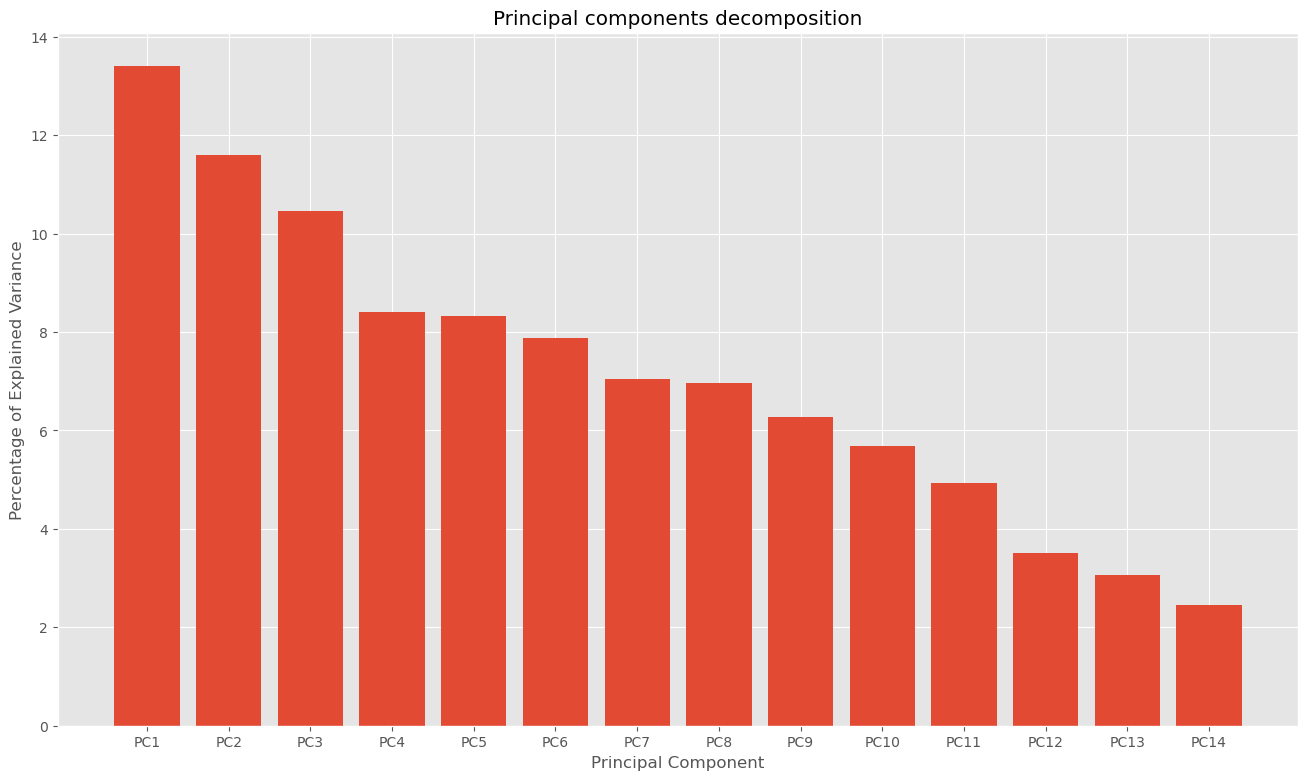

Explained variance: 
 [13.41 11.59 10.45  8.41  8.32  7.88  7.04  6.97  6.28  5.68  4.93  3.51
  3.07  2.46]


In [372]:
#Percentage of explained variance for each principal component
per_var = np.round(pca.explained_variance_ratio_* 100, decimals=2)
labels = ['PC' + str(x) for x in range(1, len(per_var)+1)]
 
plt.bar(x=range(1,len(per_var)+1), height=per_var, tick_label=labels)
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Principal Component')
plt.title('Principal components decomposition')
plt.show()

print("Explained variance: \n",per_var)

## KNN

In [373]:
scoring = {"F1": "f1", "MCC": make_scorer(matthews_corrcoef)}

In [374]:
parameters = [{'n_neighbors': range(1,21,1),
              'metric': ['manhattan','euclidean', 'chebyshev'],
               'p': range(1,4,1),
               'weights': ['uniform','distance']
                }]


grid_search = GridSearchCV(estimator = KNeighborsClassifier(),
                           param_grid = parameters,
                           scoring = scoring,
                           refit='MCC',
                           cv = 5,
                           n_jobs = 1)
grid_search.fit(x_pca, y_train)
best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_
print("Best MCC: {:.2f}".format(best_accuracy))
print("Parameters MCC:", best_parameters,'\n')
print("Best F1: {:.2f}".format(np.amax(grid_search.cv_results_['mean_test_F1'])))
print("Parameters F1",grid_search.cv_results_['params'][np.argmax(grid_search.cv_results_['mean_test_F1'])])

Best MCC: 0.52
Parameters MCC: {'metric': 'chebyshev', 'n_neighbors': 10, 'p': 1, 'weights': 'distance'} 

Best F1: 0.87
Parameters F1 {'metric': 'chebyshev', 'n_neighbors': 18, 'p': 1, 'weights': 'distance'}


## SVM

In [375]:
parameters = [{'kernel': ['linear','poly','rbf','sigmoid'],
              'degree': [2,3],
               'coef0': np.arange(0,1.2,0.2),
               'C': np.arange(0.2,1.2,0.2),
               'gamma': ['scale','auto']
                }]

grid_search = GridSearchCV(estimator = svm.SVC(random_state=0),
                           param_grid = parameters,
                           scoring = scoring,
                           refit='MCC',
                           cv = 5,
                           n_jobs = 1)
grid_search.fit(x_pca, y_train)
best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_
print("Best MCC: {:.2f}".format(best_accuracy))
print("Parameters MCC:", best_parameters,'\n')
print("Best F1: {:.2f}".format(np.amax(grid_search.cv_results_['mean_test_F1'])))
print("Parameters F1",grid_search.cv_results_['params'][np.argmax(grid_search.cv_results_['mean_test_F1'])])

Best MCC: 0.56
Parameters MCC: {'C': 0.4, 'coef0': 0.4, 'degree': 2, 'gamma': 'scale', 'kernel': 'poly'} 

Best F1: 0.88
Parameters F1 {'C': 0.4, 'coef0': 0.4, 'degree': 2, 'gamma': 'scale', 'kernel': 'poly'}


## Logistic Regression

In [376]:
parameters = [{'solver': ['sag','saga','lbfgs', 'newton-cg', 'liblinear'],
              'penalty': ['l1', 'l2', 'elasticnet', 'none'],
               'C': np.arange(0,2,0.2)
                }]
grid_search = GridSearchCV(estimator = LogisticRegression(max_iter=500),
                           param_grid = parameters,
                           scoring = scoring,
                           refit='MCC',
                           cv = 3,
                           n_jobs = -1)

grid_search.fit(x_pca, y_train)
best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_
print("Best MCC: {:.2f}".format(best_accuracy))
print("Parameters MCC:", best_parameters,'\n')
print("Best F1: {:.2f}".format(np.nanmax(grid_search.cv_results_['mean_test_F1'])))
print("Parameters F1",grid_search.cv_results_['params'][np.nanargmax(grid_search.cv_results_['mean_test_F1'])])

Best MCC: 0.56
Parameters MCC: {'C': 0.2, 'penalty': 'l1', 'solver': 'saga'} 

Best F1: 0.88
Parameters F1 {'C': 0.2, 'penalty': 'l1', 'solver': 'saga'}


## Random Forest

In [377]:
from sklearn.ensemble import RandomForestClassifier
param_grid = { 
    'n_estimators': [100,200,500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}
grid_search = GridSearchCV(RandomForestClassifier(), param_grid,scoring=scoring,refit='MCC',n_jobs=-1)
grid_search.fit(x_pca, y_train)
best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_
print("Best MCC: {:.2f}".format(best_accuracy))
print("Best Parameters:", best_parameters)
print("Best F1: {:.2f}".format(np.amax(grid_search.cv_results_['mean_test_F1'])))
print("Parameters F1",grid_search.cv_results_['params'][np.argmax(grid_search.cv_results_['mean_test_F1'])])

Best MCC: 0.54
Best Parameters: {'criterion': 'entropy', 'max_depth': 4, 'max_features': 'auto', 'n_estimators': 500}
Best F1: 0.88
Parameters F1 {'criterion': 'entropy', 'max_depth': 4, 'max_features': 'auto', 'n_estimators': 500}


## Random Forest Validation

In [378]:
clf = RandomForestClassifier(criterion='entropy',max_depth=4,max_features='auto', n_estimators=200)
clf.fit(x_pca, y_train)
x_testpca = pca.transform(x_test)
y_predict = clf.predict(x_testpca)
score2 = matthews_corrcoef(y_test,y_predict)
score3 = f1_score(y_test,y_predict)
print("MCC: {:.2f}".format(score2))
print("F1 : {:.2f}".format(score3))

MCC: 0.33
F1 : 0.85


## Logistic Regression Validation

In [379]:
clf = LogisticRegression(max_iter=500,C= 0.2,penalty='l1', solver='saga')
clf.fit(x_pca, y_train)
x_testpca = pca.transform(x_test)
y_predict = clf.predict(x_testpca)
score2 = matthews_corrcoef(y_test,y_predict)
score3 = f1_score(y_test,y_predict)
print("MCC: {:.2f}".format(score2))
print("F1 : {:.2f}".format(score3))

MCC: 0.39
F1 : 0.86


## Predictions for test data

In [380]:
df1 = pd.read_csv('data/test.csv',index_col = 'Loan_ID')
df1.sample(5)

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
Loan_ID,,,,,,,,,,,
LP001961,Female,No,0,Graduate,No,3958,0,110.0,360.0,1.0,Rural
LP001601,Male,No,3+,Graduate,No,4243,4123,157.0,360.0,NaN,Semiurban
LP002270,Male,Yes,1,Graduate,No,3436,3809,100.0,360.0,1.0,Rural
LP001124,Female,No,3+,Not Graduate,No,2083,0,28.0,180.0,1.0,Urban
LP002867,Male,No,0,Graduate,Yes,3972,4275,187.0,360.0,1.0,Rural


In [381]:
df1.isna().sum().sort_values(ascending=False) #Ascending order

Credit_History       29
Self_Employed        23
Gender               11
Dependents           10
Loan_Amount_Term      6
LoanAmount            5
Married               0
Education             0
ApplicantIncome       0
CoapplicantIncome     0
Property_Area         0
dtype: int64

In [382]:
x = df1.isna().sum().sort_values(ascending=False)
x = x.loc[x>0].index
df1['LoanAmount'] = df1['LoanAmount'].fillna(int(df1['LoanAmount'].dropna().mean()))
for col in x:
    df1[col] = df1[col].fillna(df1[col].dropna().mode().values[0]) 
df1.isna().sum().sort_values(ascending=False)

Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
dtype: int64

In [383]:
df1 = transform_categorical(df1)
df1.sample(5)

,Gender,Married,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Dependents_1,Dependents_2,Dependents_3+,Property_Area_Semiurban,Property_Area_Urban
Loan_ID,,,,,,,,,,,,,,
LP002045,1,1,1,0,10166,750,150.0,360.0,1.0,0,0,1,0,1
LP001466,1,0,1,0,3066,0,95.0,360.0,1.0,0,0,0,1,0
LP001769,1,0,1,0,3333,1250,110.0,360.0,1.0,0,0,0,1,0
LP002355,1,1,1,0,3186,3145,150.0,180.0,0.0,0,0,0,1,0
LP001211,1,0,1,1,5833,0,116.0,360.0,1.0,0,0,0,0,1


In [384]:
x1 = df1.values
x1_test = scaler.transform(x1)
x1_pca = pca.transform(x1_test)

In [385]:
y1_predict = clf.predict(x1_pca)
ids = df1.index.values
d = {'Loan_ID':ids,'Loan_Status':y1_predict}
result = pd.DataFrame(data=d)
result.sample(5)

,Loan_ID,Loan_Status
362,LP002971,1
286,LP002581,1
112,LP001589,1
317,LP002774,0
89,LP001472,1


In [386]:
result['Loan_Status']=result['Loan_Status'].map({1:'Y',0:'N'})
result.to_csv('data/prediction.csv', index=False)

In [387]:
result['Loan_Status'].value_counts()

Y    307
N     60
Name: Loan_Status, dtype: int64